In [2]:
import pandas as pd
df = pd.read_csv("daily_NVDA-shortened.csv")
df = df.iloc[::-1].reset_index(drop=True)
print(df.head())
print(df.tail())

  timestamp     open     high      low    close    volume  candle  rsi
0  2/1/2018  4.89450  4.98750  4.86250  4.98375   8303752    True  NaN
1  3/1/2018  5.10250  5.34250  5.09375  5.31175  22499518    True  NaN
2  4/1/2018  5.39400  5.45125  5.31725  5.33975  14346675   False  NaN
3  5/1/2018  5.35475  5.42275  5.27700  5.38500  14008768    True  NaN
4  8/1/2018  5.51000  5.62500  5.46450  5.55000  21190932    True  NaN
       timestamp    open    high     low   close     volume  candle        rsi
1758  27/12/2024  138.55  139.02  134.71  137.01  170582603   False  50.000000
1759  30/12/2024  134.83  140.27  134.02  137.49  167734700    True  57.142857
1760  31/12/2024  138.03  138.07  133.83  134.29  155659211   False  57.142857
1761    2/1/2025  136.00  138.88  134.63  138.31  198247166    True  57.142857
1762    3/1/2025  140.01  144.90  139.73  144.47  229322478    True  57.142857


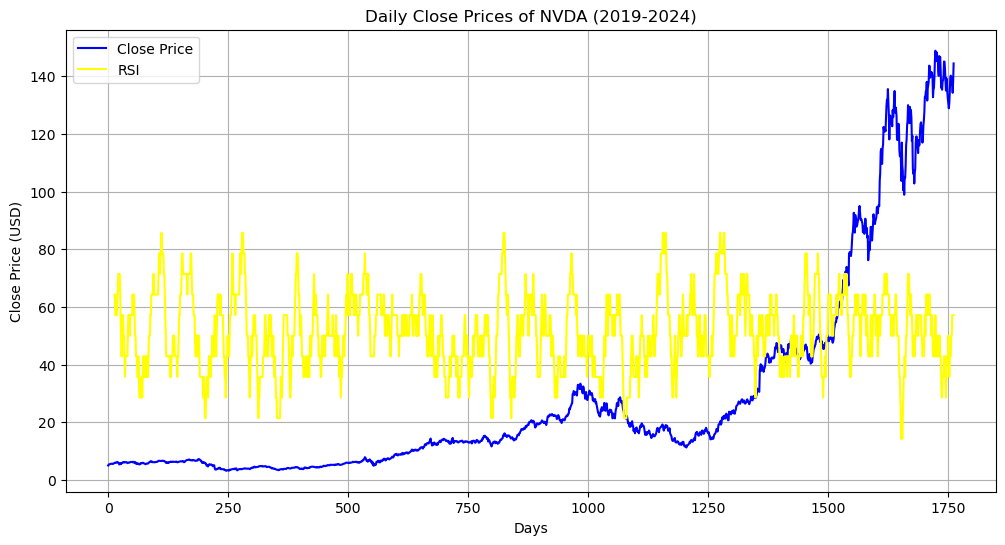

In [4]:
MIN_RSI = 28
MAX_RSI = 100 - MIN_RSI
TP = 0.0  # Take profit: 0.8%
SL = 0.005  # Stop loss: 0.5%

# Initialize variables for logging results
profit_loss_log = []
open_positions = []

# Iterate through data
for i, row in df.iterrows():
    close_price = row["close"]
    rsi = row["rsi"]

    # Check open positions
    updated_positions = []
    for position in open_positions:
        if position["type"] == "LONG":
            tp_price = position["entry"] * (1 + TP)
            sl_price = position["entry"] * (1 - SL)
            if close_price >= tp_price:
                profit_loss_log.append((tp_price - position["entry"])/position["entry"]*100)
            elif close_price <= sl_price:
                profit_loss_log.append((sl_price - position["entry"])/position["entry"]*100)
            else:
                updated_positions.append(position)
        elif position["type"] == "SHORT":
            tp_price = position["entry"] * (1 - TP)
            sl_price = position["entry"] * (1 + SL)
            if close_price <= tp_price:
                profit_loss_log.append((position["entry"] - tp_price)/position["entry"]*100)
            elif close_price >= sl_price:
                profit_loss_log.append((position["entry"] - sl_price)/position["entry"]*100)
            else:
                updated_positions.append(position)

    open_positions = updated_positions

    if rsi < MIN_RSI:
        open_positions.append({"type": "LONG", "entry": close_price})
    elif rsi > MAX_RSI:
        open_positions.append({"type": "SHORT", "entry": close_price})


In [5]:
MIN_RSI = 40
MAX_RSI = 80
TP = 0.10  # Take profit: 10%
SL = 0.05  # Stop loss: 5%

# Initialize variables for logging results
profit_loss_log = []
trade_log = []
open_positions = []
total_trades = 0
winning_trades = 0
time_in_trades = []

# Open log file
with open("trade_log.txt", "w") as log_file:
    log_file.write("Trade Log\n")
    log_file.write("=" * 40 + "\n")

    # Iterate through data
    for i, row in df.iterrows():
        close_price = row["close"]
        rsi = row["rsi"]
        current_date = row["timestamp"]  # Assuming a 'date' column in the DataFrame

        # Check open positions
        updated_positions = []
        for position in open_positions:
            if position["type"] == "LONG":
                tp_price = position["entry"] * (1 + TP)
                sl_price = position["entry"] * (1 - SL)
                if close_price >= tp_price or close_price <= sl_price:
                    # Calculate profit/loss
                    result = (
                        (tp_price - position["entry"]) / position["entry"] * 100
                        if close_price >= tp_price
                        else (sl_price - position["entry"]) / position["entry"] * 100
                    )
                    profit_loss_log.append(result)
                    trade_log.append(
                        f"Trade {total_trades + 1}: Entered LONG @ {position['entry']} on {position['entry_date']} "
                        f"and EXITED @ {close_price} on {current_date} for a profit/loss of {result:.2f}%\n"
                    )
                    log_file.write(trade_log[-1])
                    total_trades += 1
                    if result > 0:
                        winning_trades += 1
                else:
                    updated_positions.append(position)
            elif position["type"] == "SHORT":
                tp_price = position["entry"] * (1 - TP)
                sl_price = position["entry"] * (1 + SL)
                if close_price <= tp_price or close_price >= sl_price:
                    # Calculate profit/loss
                    result = (
                        (position["entry"] - tp_price) / position["entry"] * 100
                        if close_price <= tp_price
                        else (position["entry"] - sl_price) / position["entry"] * 100
                    )
                    profit_loss_log.append(result)
                    trade_log.append(
                        f"Trade {total_trades + 1}: Entered SHORT @ {position['entry']} on {position['entry_date']} "
                        f"and EXITED @ {close_price} on {current_date} for a profit/loss of {result:.2f}%\n"
                    )
                    log_file.write(trade_log[-1])
                    total_trades += 1
                    if result > 0:
                        winning_trades += 1
                else:
                    updated_positions.append(position)

        open_positions = updated_positions

        # Check for new trades
        if rsi < MIN_RSI:
            open_positions.append(
                {"type": "LONG", "entry": close_price, "entry_date": current_date}
            )
        elif rsi > MAX_RSI:
            open_positions.append(
                {"type": "SHORT", "entry": close_price, "entry_date": current_date}
            )

    # Calculate and log statistics
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0

    log_file.write("\nSummary Statistics\n")
    log_file.write("=" * 40 + "\n")
    log_file.write(f"Total Trades: {total_trades}\n")
    log_file.write(f"Win Rate: {win_rate:.2f}%\n")
    log_file.write(f"Total Profit/Loss: {sum(profit_loss_log):.2f}%\n")

# Console outputs
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Total Profit/Loss: {sum(profit_loss_log):.2f}%")
print(profit_loss_log)


Total Trades: 297
Win Rate: 47.47%
Total Profit/Loss: 630.00%
[-5.0000000000000036, 10.000000000000009, 10.000000000000014, -4.999999999999997, -5.000000000000008, -5.000000000000011, -5.000000000000003, -5.0000000000000115, 10.000000000000012, 10.000000000000014, 10.000000000000012, 10.000000000000012, 10.000000000000014, 10.000000000000012, 10.000000000000014, 10.000000000000005, 10.000000000000014, 9.999999999999993, 10.000000000000007, 10.000000000000012, 10.000000000000004, -5.000000000000006, -4.999999999999998, -5.00000000000001, -5.000000000000001, -5.000000000000009, -5.000000000000005, -5.000000000000003, -5.000000000000011, -5.0000000000000036, -5.0, -4.999999999999997, -4.9999999999999964, -5.000000000000009, -4.999999999999998, -5.000000000000008, -5.000000000000005, -5.000000000000002, 10.000000000000005, -5.000000000000003, -4.999999999999998, -5.000000000000012, -5.000000000000004, -5.00000000000001, 10.000000000000012, 10.00000000000001, -5.0000000000000036, -5.0000000